In [1]:
#https://github.com/NVlabs/SPADE

In [2]:
# torch 1.6 for mixed precision training
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 6.5 kB/s 
     |████████████████████████████████| 5.9 MB 44.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+35d732a
    Uninstalling torchvision-0.6.0a0+35d732a:
      Successfully uninstalled torchvision-0.6.0a0+35d732a
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.6.0+cu101 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m 

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
from torch.nn.utils import spectral_norm
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid, save_image
from torch.cuda import amp
%matplotlib inline

In [4]:
print(torch.__version__) # 1.6

1.6.0+cu101


# Data

In [5]:
DATA_DIR = '../input/ade20k-outdoors/'

IMG_DIR = DATA_DIR + 'images/training'                           
SEGMENTATION_MASK_DIR = DATA_DIR + 'annotations/training'  

In [6]:
img_id = os.listdir(IMG_DIR)
img_id.remove('ADE_train_00003020.jpg')
img_id.remove('ADE_train_00013508.jpg')
# ADE_train_00003020.jpg
# ADE_train_00013508.jpg
# bad bad bad

In [7]:
training_img_id = img_id[:4800]
valid_img_id = img_id[4800:]

In [8]:
image_size = (256,256)
batch_size = 25

ds_T = T.Compose([
    T.Resize(image_size),
    T.ToTensor()])

In [9]:
class ade20k_outdoors_ds(Dataset):
    def __init__(self, IMG_DIR, SEGMENTATION_MASK_DIR, img_id, transform=None):
        self.transform = transform
        self.IMG_DIR = IMG_DIR
        self.SEGMENTATION_MASK_DIR = SEGMENTATION_MASK_DIR
        self.img_id = img_id
        self.norm = T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        
    def __len__(self):
        return len(self.img_id)  
    
    def __getitem__(self, idx):
        img = self.img_id[idx]
        img_fname = self.IMG_DIR + "/" + str(img)
        segmask_fname = self.SEGMENTATION_MASK_DIR + "/" + str(img).replace("jpg", "png")
        img = Image.open(img_fname)
        mask = Image.open(segmask_fname)
        
        if self.transform:
            img = self.transform(img)
            img = self.norm(img)
            mask = self.transform(mask)
            mask = mask * 255.0 - 1
            mask[mask == -1] = 149 # unknown label becomes last label
        return img, mask

In [10]:
train_ds = ade20k_outdoors_ds(IMG_DIR, SEGMENTATION_MASK_DIR, training_img_id, transform=ds_T)
train_dl = DataLoader(train_ds, batch_size, shuffle=False, num_workers=3, pin_memory=True)

val_ds = ade20k_outdoors_ds(IMG_DIR, SEGMENTATION_MASK_DIR, valid_img_id, transform=ds_T)
val_dl = DataLoader(val_ds, batch_size, shuffle=False, num_workers=3, pin_memory=True)

print(len(train_ds), len(val_ds))

4800 198


In [11]:
def show_batch(dl, mask = False):
    for images, masks in dl:
        #print(images.shape, masks.shape)
        fig, ax0 = plt.subplots(figsize=(8,8))
        ax0.set_xticks([]); ax0.set_yticks([])
        if not mask:
            ax0.imshow(make_grid(images * 0.5 + 0.5, nrow=5).permute(1, 2, 0))
        else:
            ax0.imshow(make_grid(masks / 255.0, nrow=5).permute(1, 2, 0))
        break

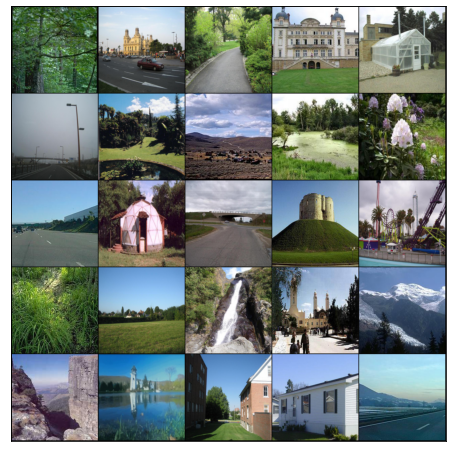

In [12]:
show_batch(train_dl, False)

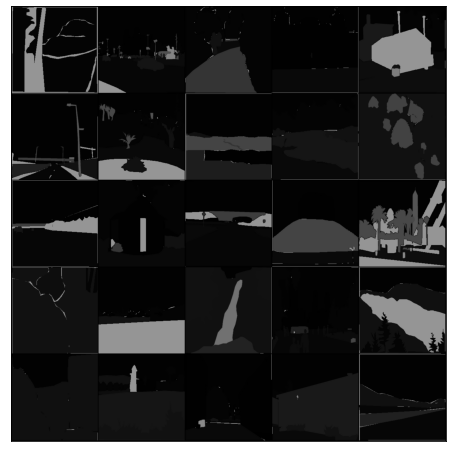

In [13]:
show_batch(train_dl, True)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Models

In [17]:
class Spade(nn.Module):
    def __init__(self, num_chanels_activation, num_chanels_input_semantic_map):

        super().__init__()
        
        self.normalization = nn.BatchNorm2d(num_chanels_activation, affine=False)
        
        self.mlp_shared = nn.Sequential(
            nn.Conv2d(num_chanels_input_semantic_map, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.mlp_gamma = nn.Conv2d(128, num_chanels_activation, kernel_size=3, padding=1)
        self.mlp_beta = nn.Conv2d(128, num_chanels_activation, kernel_size=3, padding=1)
        
    def forward(self, x, segmap):
        
        norm = self.normalization(x)
        
        segmap = F.interpolate(segmap, size=x.size()[2:], mode='nearest')
        
        actv = self.mlp_shared(segmap)
        gamma = self.mlp_gamma(actv)
        beta = self.mlp_beta(actv)
        out = norm * (1 + gamma) + beta
        return out

In [18]:
class SpadeResblock(nn.Module):
    def __init__(self, dim_in, dim_out, num_chanels_input_semantic_map = 150):
        super().__init__()
        
        self.skip_conection = dim_in != dim_out # in case of them being different, we use a spade block on the skip conection
        
        # conv layers
        self.conv_0 = spectral_norm(nn.Conv2d(dim_in, dim_out, kernel_size=3, padding=1))
        self.conv_1 = spectral_norm(nn.Conv2d(dim_out, dim_out, kernel_size=3, padding=1))
        
        # 1x1 conv to make sizes match
        if self.skip_conection:
            self.conv_s = spectral_norm(nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=False))
                                    
        # spade layers
        self.norm_0 = Spade(dim_in, num_chanels_input_semantic_map)
        self.norm_1 = Spade(dim_out, num_chanels_input_semantic_map)
        if self.skip_conection:
            self.norm_s = Spade(dim_in, num_chanels_input_semantic_map)
                                    
    def forward(self, x, seg):
        x_s = self.shortcut(x, seg)

        dx = self.conv_0(F.leaky_relu(self.norm_0(x, seg), 0.2))
        dx = self.conv_1(F.leaky_relu(self.norm_1(dx, seg), 0.2))
        #print(x_s.shape, dx.shape)
        out = x_s + dx

        return out

    def shortcut(self, x, seg):
        if self.skip_conection:
            x_s = self.conv_s(self.norm_s(x, seg))
        else:
            x_s = x
        return x_s

In [19]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(256,16384)
        
        self.head = SpadeResblock(1024, 1024)
        self.mid = SpadeResblock(1024,512)
        self.up_0 = SpadeResblock(512, 256)
        self.up_1 = SpadeResblock(256, 128)
        self.up_2 = SpadeResblock(128, 64)
        
        self.conv = nn.Conv2d(64, 3, stride=1, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2)
        
    def forward(self, x, segmap):
        x = x.view(x.size()[0], -1)  # batch x 256 x 1
        
        x = self.linear(x)
        
        x = x.view(x.size()[0], 1024, 4, 4)
        
        x = self.head(x, segmap)
        x = self.up(x) # 8 x 8
        
        x = self.head(x, segmap)
        x = self.up(x) # 16 x 16
        
        x = self.mid(x, segmap)
        x = self.up(x) # 32 x 32
        
        x = self.up_0(x, segmap)
        x = self.up(x) # 64 x 64
        
        x = self.up_1(x, segmap)
        x = self.up(x) # 128 x 128
        
        x = self.up_2(x, segmap)
        x = self.up(x) # 256 x 256
        
        x = self.conv(x) # fix channels
        out = torch.tanh(x)
        
        return out

In [20]:
class discriminator(nn.Module):
    # regular convnet, but at the end we have NxN vector instead of a true/false, each pixel of the NxN tells out abou the veracity of a patch
    # the loss_fm computes the feature matching loss on each sub module
    def __init__(self):
        super().__init__()
        
        # batch x 4 x 256 x 256 input // seg map is on greyscale, so 4 instead of 6
        sequence = [
            [spectral_norm(nn.Conv2d(3+150, 64, kernel_size=4, stride=2, padding=2)), # 150 classes
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)],
            [spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)), 
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2)],
            [spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=2)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2)],
            [spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=2)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2)],
            [nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=2)] 
        ]
        
        for n in range(len(sequence)):
            self.add_module(str(n), nn.Sequential(*sequence[n]))
        
        #self.model = nn.Sequential(*sequence)
        
    def forward(self, x):
        results = [x] # real and fake will be in same batch to have nice stats
        for submodel in self.children():
            intermediate_output = submodel(results[-1])
            results.append(intermediate_output)

        return results[1:] # return all the outputs of intermediate layers (for feature matching loss) + last layer (patchgan hinge loss)

In [21]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), # batch x 64 x 256 x 256
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # batch x 128 x 64 x 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # batch x 256 x 32 x 32
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # batch x 512 x 16 x 16
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # batch x 512 x 8 x 8
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
            
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # batch x 512 x 4 x 4 
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.mean = nn.Linear(8192, 256)
        self.var = nn.Linear(8192, 256)
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size()[0], -1)
        m = self.mean(x)
        var = self.var(x)
        return m, var

# Losses

In [22]:
# perceptual loss
class VGG19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out    

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = to_device(VGG19(), get_default_device())
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())
        return loss

In [23]:
# KL Divergence loss used in the encoder
def KLDLoss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [24]:
# feature matching using L1 norm, sharper images
def fm(D_real_out_gen, D_fake_out_gen):
    loss = torch.zeros(1).to('cuda')
    l1_l = nn.L1Loss()
    for i in range(len(D_real_out_gen) - 1): # exclude last one
        loss = loss + l1_l(D_real_out_gen[i], D_fake_out_gen[i]) / len(D_real_out_gen) 
    return loss

In [25]:
#a = torch.ones(2,2,2)
#b = torch.ones(2,2,2)
#result = nn.L1Loss()(a,b)
#print(result)

# Generate and discriminate and reparameterize

In [26]:
def discriminate(discriminator, G_out_for_discrim, real_image, semantic):
    
    D_real_input = torch.cat((real_image, semantic), dim=1)
    D_fake_input = torch.cat((G_out_for_discrim, semantic), dim=1)
    
    D_real_and_fake = torch.cat((D_real_input, D_fake_input), dim=0)
    D_out = discriminator(D_real_and_fake)
            
    D_real_out = []
    D_fake_out = []
    for tensor in D_out:
        D_real_out.append(tensor[:tensor.size(0) // 2]) # first half is real
        D_fake_out.append(tensor[tensor.size(0) // 2:]) # second half is fake
    
    return D_real_out, D_fake_out

In [27]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std) + mu

# Helper functions

In [28]:
def save_samples(Trainer, index, val_dl, sample_dir, show=False):
    with torch.no_grad():
        for images, seg in val_dl:
            fname = 'generated-images-{0:0=4d}.png'.format(index)
            one_hot_label_map = torch.zeros(25, 150, 256, 256).to('cuda')
            input_semantics = one_hot_label_map.scatter_(1, seg.long(), 1.0)
            G_out = Trainer.forward_g(images, input_semantics)
            G_out = G_out * 0.5 + 0.5
            save_image(G_out, os.path.join(sample_dir, fname), nrow=5)
            print("saving " + fname)
            if show:
                fig, ax = plt.subplots(figsize=(8,8))
                ax.set_xticks([]); ax.set_yticks([])
                ax.imshow(make_grid(G_out.cpu().detach(), nrow=5).permute(1, 2, 0))
            break
            
def get_losses_and_lrs(Trainer):
    return Trainer.losses_g, Trainer.losses_d, Trainer.lrg, Trainer.lrd

def getlr(optimizer):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    return lr

def save_models(Trainer, epoch):
    torch.save({
        'epoch': epoch,
        'G_state_dict': Trainer.G.state_dict(),
        'D_state_dict': Trainer.D.state_dict(),
        'E_state_dict': Trainer.E.state_dict(),
        'opt_g_state_dict': Trainer.opt_g.state_dict(),
        'opt_d_state_dict': Trainer.opt_d.state_dict(),
        'losses_g': Trainer.losses_g,
        'losses_d': Trainer.losses_d,
        'lrg': Trainer.lrg,
        'lrd': Trainer.lrd,
        'scaler_state_dict': Trainer.scaler.state_dict(),
        }, "checkpoint" + str(epoch) + ".pth")
    
def initialize_networks(Trainer, continue_training, epoch):
        
    device = get_default_device()
        
    G = to_device(generator(), device)
    D = to_device(discriminator(), device)
    E = to_device(encoder(), device)
        
    losses_g = [] # hinge, perceptual and kdloss
    losses_d = [] # hinge
                  
    lrg = []
    lrd = []
        
    # mixed precision training
    scaler = amp.GradScaler()
    opt_d = torch.optim.Adam(D.parameters(), betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(list(G.parameters()) + list(E.parameters()), betas=(0.5, 0.999))
        
    if continue_training:
        checkpoint = torch.load("../input/testrun-budget-gaugan-2/checkpoint" + str(epoch) + ".pth")

        G.load_state_dict(checkpoint['G_state_dict'])
        D.load_state_dict(checkpoint['D_state_dict'])
        E.load_state_dict(checkpoint['E_state_dict'])

        opt_d.load_state_dict(checkpoint['opt_d_state_dict'])
        opt_g.load_state_dict(checkpoint['opt_g_state_dict'])
            
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
            
        losses_g = checkpoint['losses_g']
        losses_d = checkpoint['losses_d']
                  
        lrg = checkpoint['lrg']
        lrd = checkpoint['lrd']
                  
        print("loaded checkpoint" + str(epoch) + ".pth")
            
    return G, D, E, scaler, opt_g, opt_d, losses_g, losses_d, lrg, lrd

# Trainer

In [29]:
class Trainer():
    def __init__(self, continue_training = False, epoch = ""):
        
        self.G, self.D, self.E, self.scaler, self.opt_g, self.opt_d, self.losses_g, self.losses_d, self.lrg, self.lrd = initialize_networks(self, continue_training, epoch)
        
    def forward_g(self, real_image, semantic):
        mu, logvar = self.E(real_image)
        z = reparameterize(mu, logvar)       
        G_out = self.G(z, semantic)
        return G_out
        
    def discriminator_one_step(self, real_image, semantic):
        self.opt_d.zero_grad()
        with amp.autocast():
            with torch.no_grad():
                mu, logvar = self.E(real_image)
                z = reparameterize(mu, logvar)
                G_out = self.G(z, semantic)
                G_out = G_out.detach()
                G_out.requires_grad_()
            
            D_real_out, D_fake_out = discriminate(self.D, G_out, real_image, semantic)
            
            d_loss_real = torch.clamp(1.0 - D_real_out[-1], min=0).mean()
            d_loss_fake = torch.clamp(1.0 + D_fake_out[-1], min=0).mean()
            d_loss = (d_loss_real + d_loss_fake).mean()
        
        self.scaler.scale(d_loss).backward()
        self.scaler.step(self.opt_d)
        self.scaler.update()
        
        return d_loss, d_loss_real, d_loss_fake
        
    def generator_one_step(self, real_image, semantic, VGGloss):
        self.opt_g.zero_grad()
        with amp.autocast():
            mu, logvar = self.E(real_image)
            z = reparameterize(mu, logvar)
            
            G_out = self.G(z, semantic)
            D_real_out, D_fake_out = discriminate(self.D, G_out, real_image, semantic)
            
            perceptual_loss = 10 * VGGloss(G_out, real_image)
            kdl = 0.05 * KLDLoss(mu, logvar)
            hinge_g = - D_fake_out[-1].mean()
            feature_matching_loss = 10 * fm(D_real_out, D_fake_out)
            
            g_loss = (hinge_g + perceptual_loss + kdl + feature_matching_loss).mean()
        
        self.scaler.scale(g_loss).backward()
        self.scaler.step(self.opt_g)
        self.scaler.update()
        
        return g_loss, hinge_g, perceptual_loss, kdl, feature_matching_loss
        
    def fit_one_cycle(self, trail_dl, val_dl, epochs, lr, show = False, index = 0):
        torch.cuda.empty_cache()
        
        VGGloss = VGGLoss()
        
        for param_group in self.opt_d.param_groups:
            param_group['lr'] = lr * 2
        for param_group in self.opt_g.param_groups:
            param_group['lr'] = lr / 2
        
        # from epoch 50 to 100 no scheduler
        #scheduler_d = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.opt_d, T_0=(epochs+1)//3*192)
        #scheduler_g = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.opt_g, T_0=(epochs+1)//3*192)
        
        for epoch in range(epochs + 1):
            for real_image, semantic in tqdm(train_dl):
                
                # one hot encoded label map
                
                one_hot_label_map = torch.zeros(25, 150, 256, 256).to('cuda')
                input_semantics = one_hot_label_map.scatter_(1, semantic.long(), 1.0)
                
                # train discriminator each X steps?
                d_loss, d_loss_real, d_loss_fake = self.discriminator_one_step(real_image, input_semantics)
                self.losses_d.append((d_loss.detach().item(), d_loss_real.detach().item(), d_loss_fake.detach().item()))
                    
                
                g_loss, hinge_g, perceptual_loss, kdl, feature_matching_loss = self.generator_one_step(real_image, input_semantics, VGGloss)
                self.losses_g.append((g_loss.detach().item(), 
                                      hinge_g.detach().item(), 
                                      perceptual_loss.detach().item(), 
                                      kdl.detach().item(),
                                      feature_matching_loss.detach().item())) 
                    
                self.lrd.append(getlr(self.opt_d))
                self.lrg.append(getlr(self.opt_g))
                
                #scheduler_g.step()
                #scheduler_d.step()
            
            print("Epoch [{}/{}], d_loss: {:.8f}, d_loss_real: {:.8f}, d_loss_fake: {:.8f}, g_loss: {:.8f}, perceptual_loss: {:.8f}, kdl: {:.8f}, hinge_g: {:.8f}, feature_matching: {:.8f}"
                  .format(epoch, epochs, d_loss, d_loss_real, d_loss_fake, g_loss, perceptual_loss, kdl, hinge_g, feature_matching_loss.item()))
                           
            if(epoch%25 == 0 and epoch != 0):
                save_models(self, epoch + index)
            if(epoch%1 == 0 and epoch != 0):
                save_samples(self, epoch + index, val_dl, sample_dir, show)

In [30]:
#GauganTrainer = Trainer()

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
#save_samples(GauganTrainer, 0, val_dl, sample_dir, show = True)

In [33]:
#GauganTrainer.fit_one_cycle(train_dl, val_dl, 50, lr = 0.0003)

In [34]:
GauganTrainer = Trainer(continue_training=True, epoch = 50)

loaded checkpoint50.pth


In [35]:
GauganTrainer.fit_one_cycle(train_dl, val_dl, 50, lr = 0.0003, index=50)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Epoch [0/50], d_loss: 1.56835938, d_loss_real: 0.97509766, d_loss_fake: 0.59375000, g_loss: 12.06207561, perceptual_loss: 7.93669701, kdl: 0.93147022, hinge_g: 0.31884766, feature_matching: 2.87506104



Epoch [1/50], d_loss: 1.62500000, d_loss_real: 0.42724609, d_loss_fake: 1.19726562, g_loss: 11.99724865, perceptual_loss: 8.00483131, kdl: 0.51097167, hinge_g: 0.61523438, feature_matching: 2.86621094
saving generated-images-0051.png



Epoch [2/50], d_loss: 1.61816406, d_loss_real: 1.22460938, d_loss_fake: 0.39379883, g_loss: 10.93266106, perceptual_loss: 8.05385399, kdl: 0.38155350, hinge_g: -0.36987305, feature_matching: 2.86712646
saving generated-images-0052.png



Epoch [3/50], d_loss: 1.49511719, d_loss_real: 1.29785156, d_loss_fake: 0.19763184, g_loss: 10.85930634, perceptual_loss: 8.08809471, kdl: 0.30862576, hinge_g: -0.38867188, feature_matching: 2.85125732
saving generated-images-0053.png



Epoch [4/50], d_loss: 1.68554688, d_loss_real: 1.38769531, d_loss_fake: 0.29736328, g_loss: 11.20450115, perceptual_loss: 8.08771610, kdl: 0.28565812, hinge_g: -0.00670242, feature_matching: 2.83782959
saving generated-images-0054.png



Epoch [5/50], d_loss: 1.59277344, d_loss_real: 1.35937500, d_loss_fake: 0.23303223, g_loss: 11.28078270, perceptual_loss: 8.12924480, kdl: 0.26762700, hinge_g: -0.06103516, feature_matching: 2.94494629
saving generated-images-0055.png



Epoch [6/50], d_loss: 1.29003906, d_loss_real: 0.87060547, d_loss_fake: 0.41943359, g_loss: 11.54319382, perceptual_loss: 8.04807949, kdl: 0.32635233, hinge_g: 0.27172852, feature_matching: 2.89703369
saving generated-images-0056.png



Epoch [7/50], d_loss: 1.39843750, d_loss_real: 0.64941406, d_loss_fake: 0.74853516, g_loss: 11.99798489, perceptual_loss: 8.06431866, kdl: 0.28815866, hinge_g: 0.72314453, feature_matching: 2.92236328
saving generated-images-0057.png



Epoch [8/50], d_loss: 1.58007812, d_loss_real: 1.16601562, d_loss_fake: 0.41430664, g_loss: 11.27603245, perceptual_loss: 8.06779099, kdl: 0.28197184, hinge_g: 0.16564941, feature_matching: 2.76062012
saving generated-images-0058.png



Epoch [9/50], d_loss: 1.36523438, d_loss_real: 1.10449219, d_loss_fake: 0.26025391, g_loss: 11.18773270, perceptual_loss: 8.07473469, kdl: 0.35103479, hinge_g: -0.08654785, feature_matching: 2.84851074
saving generated-images-0059.png



Epoch [10/50], d_loss: 1.52539062, d_loss_real: 1.33789062, d_loss_fake: 0.18762207, g_loss: 10.91316319, perceptual_loss: 8.06978130, kdl: 0.26446319, hinge_g: -0.27050781, feature_matching: 2.84942627
saving generated-images-0060.png



Epoch [11/50], d_loss: 1.29101562, d_loss_real: 0.54882812, d_loss_fake: 0.74169922, g_loss: 12.11565495, perceptual_loss: 8.08496952, kdl: 0.34654242, hinge_g: 0.84814453, feature_matching: 2.83599854
saving generated-images-0061.png



Epoch [12/50], d_loss: 1.46875000, d_loss_real: 0.56298828, d_loss_fake: 0.90527344, g_loss: 12.20671082, perceptual_loss: 8.08472157, kdl: 0.46744844, hinge_g: 0.85546875, feature_matching: 2.79907227
saving generated-images-0062.png



Epoch [13/50], d_loss: 1.40136719, d_loss_real: 0.98876953, d_loss_fake: 0.41235352, g_loss: 12.20880127, perceptual_loss: 8.10372448, kdl: 0.85983795, hinge_g: 0.41137695, feature_matching: 2.83386230
saving generated-images-0063.png



Epoch [14/50], d_loss: 1.24218750, d_loss_real: 0.83349609, d_loss_fake: 0.40820312, g_loss: 12.05857849, perceptual_loss: 8.08813667, kdl: 0.72923130, hinge_g: 0.38598633, feature_matching: 2.85522461
saving generated-images-0064.png



Epoch [15/50], d_loss: 1.44140625, d_loss_real: 1.23144531, d_loss_fake: 0.21044922, g_loss: 11.29794502, perceptual_loss: 8.05475616, kdl: 0.56624788, hinge_g: -0.14868164, feature_matching: 2.82562256
saving generated-images-0065.png



Epoch [16/50], d_loss: 1.43554688, d_loss_real: 1.15234375, d_loss_fake: 0.28320312, g_loss: 11.47792053, perceptual_loss: 8.03823948, kdl: 0.76652443, hinge_g: -0.09173584, feature_matching: 2.76489258
saving generated-images-0066.png



Epoch [17/50], d_loss: 1.41796875, d_loss_real: 0.86083984, d_loss_fake: 0.55761719, g_loss: 12.38873005, perceptual_loss: 8.10196877, kdl: 1.08168304, hinge_g: 0.40722656, feature_matching: 2.79785156
saving generated-images-0067.png



Epoch [18/50], d_loss: 1.45312500, d_loss_real: 1.16406250, d_loss_fake: 0.28955078, g_loss: 11.56203938, perceptual_loss: 8.09162712, kdl: 0.80433553, hinge_g: -0.12078857, feature_matching: 2.78686523
saving generated-images-0068.png



Epoch [19/50], d_loss: 1.53027344, d_loss_real: 0.95361328, d_loss_fake: 0.57666016, g_loss: 12.25918579, perceptual_loss: 8.05811977, kdl: 0.96217424, hinge_g: 0.44287109, feature_matching: 2.79602051
saving generated-images-0069.png



Epoch [20/50], d_loss: 1.53710938, d_loss_real: 1.11621094, d_loss_fake: 0.42114258, g_loss: 12.04201221, perceptual_loss: 8.12776279, kdl: 0.78882247, hinge_g: 0.30834961, feature_matching: 2.81707764
saving generated-images-0070.png



Epoch [21/50], d_loss: 1.35449219, d_loss_real: 0.91406250, d_loss_fake: 0.44067383, g_loss: 12.77961540, perceptual_loss: 8.05197144, kdl: 1.25791764, hinge_g: 0.60595703, feature_matching: 2.86376953
saving generated-images-0071.png



Epoch [22/50], d_loss: 1.51464844, d_loss_real: 1.31542969, d_loss_fake: 0.19885254, g_loss: 12.50390625, perceptual_loss: 8.09189796, kdl: 1.51286840, hinge_g: 0.05459595, feature_matching: 2.84454346
saving generated-images-0072.png



Epoch [23/50], d_loss: 1.41210938, d_loss_real: 0.33544922, d_loss_fake: 1.07617188, g_loss: 13.12282181, perceptual_loss: 8.14515305, kdl: 0.80908918, hinge_g: 1.31152344, feature_matching: 2.85705566
saving generated-images-0073.png



Epoch [24/50], d_loss: 1.44726562, d_loss_real: 1.13964844, d_loss_fake: 0.30737305, g_loss: 11.81078148, perceptual_loss: 8.13650608, kdl: 0.86064607, hinge_g: -0.04525757, feature_matching: 2.85888672
saving generated-images-0074.png



Epoch [25/50], d_loss: 1.47167969, d_loss_real: 1.29687500, d_loss_fake: 0.17480469, g_loss: 11.73984814, perceptual_loss: 8.06690216, kdl: 0.93207085, hinge_g: -0.04995728, feature_matching: 2.79083252
saving generated-images-0075.png



Epoch [26/50], d_loss: 1.37890625, d_loss_real: 0.88085938, d_loss_fake: 0.49780273, g_loss: 11.92276382, perceptual_loss: 8.13037300, kdl: 0.48983932, hinge_g: 0.49951172, feature_matching: 2.80303955
saving generated-images-0076.png



Epoch [27/50], d_loss: 1.41015625, d_loss_real: 0.88720703, d_loss_fake: 0.52294922, g_loss: 11.64706993, perceptual_loss: 8.13345337, kdl: 0.60141557, hinge_g: 0.05209351, feature_matching: 2.86010742
saving generated-images-0077.png



Epoch [28/50], d_loss: 1.37792969, d_loss_real: 0.94189453, d_loss_fake: 0.43579102, g_loss: 11.81597328, perceptual_loss: 8.08209515, kdl: 0.66783816, hinge_g: 0.20776367, feature_matching: 2.85827637
saving generated-images-0078.png



Epoch [29/50], d_loss: 1.21484375, d_loss_real: 0.76904297, d_loss_fake: 0.44580078, g_loss: 13.36581802, perceptual_loss: 8.10269737, kdl: 2.06420755, hinge_g: 0.35620117, feature_matching: 2.84271240
saving generated-images-0079.png



Epoch [30/50], d_loss: 1.29296875, d_loss_real: 0.93359375, d_loss_fake: 0.35913086, g_loss: 11.63333893, perceptual_loss: 8.08442116, kdl: 0.59567100, hinge_g: 0.09985352, feature_matching: 2.85339355
saving generated-images-0080.png



Epoch [31/50], d_loss: 1.34375000, d_loss_real: 0.92138672, d_loss_fake: 0.42285156, g_loss: 17.66271019, perceptual_loss: 8.08382416, kdl: 6.32217264, hinge_g: 0.38012695, feature_matching: 2.87658691
saving generated-images-0081.png



Epoch [32/50], d_loss: 1.34570312, d_loss_real: 0.99316406, d_loss_fake: 0.35253906, g_loss: 11.34275532, perceptual_loss: 8.13320637, kdl: 0.23896812, hinge_g: 0.21301270, feature_matching: 2.75756836
saving generated-images-0082.png



Epoch [33/50], d_loss: 1.24609375, d_loss_real: 0.71289062, d_loss_fake: 0.53369141, g_loss: 11.89255333, perceptual_loss: 8.13100529, kdl: 0.27363330, hinge_g: 0.64306641, feature_matching: 2.84484863
saving generated-images-0083.png



Epoch [34/50], d_loss: 1.54101562, d_loss_real: 1.24609375, d_loss_fake: 0.29516602, g_loss: 11.17427635, perceptual_loss: 8.15744686, kdl: 0.28135607, hinge_g: -0.11395264, feature_matching: 2.84942627
saving generated-images-0084.png



Epoch [35/50], d_loss: 1.35839844, d_loss_real: 0.57910156, d_loss_fake: 0.77929688, g_loss: 12.41024590, perceptual_loss: 8.11641121, kdl: 0.70948458, hinge_g: 0.77001953, feature_matching: 2.81433105
saving generated-images-0085.png



Epoch [36/50], d_loss: 1.43554688, d_loss_real: 0.78613281, d_loss_fake: 0.64941406, g_loss: 12.05651569, perceptual_loss: 8.10359192, kdl: 0.48881227, hinge_g: 0.62353516, feature_matching: 2.84057617
saving generated-images-0086.png



Epoch [37/50], d_loss: 1.33789062, d_loss_real: 0.68603516, d_loss_fake: 0.65185547, g_loss: 12.28531647, perceptual_loss: 8.06472111, kdl: 0.91725028, hinge_g: 0.53662109, feature_matching: 2.76672363
saving generated-images-0087.png



Epoch [38/50], d_loss: 1.52539062, d_loss_real: 1.21679688, d_loss_fake: 0.30859375, g_loss: 11.47543907, perceptual_loss: 8.03475475, kdl: 0.70417356, hinge_g: -0.07598877, feature_matching: 2.81250000
saving generated-images-0088.png



Epoch [39/50], d_loss: 1.36132812, d_loss_real: 0.89306641, d_loss_fake: 0.46850586, g_loss: 13.29839802, perceptual_loss: 8.02504349, kdl: 2.03659892, hinge_g: 0.47094727, feature_matching: 2.76580811
saving generated-images-0089.png



Epoch [40/50], d_loss: 1.29492188, d_loss_real: 1.05468750, d_loss_fake: 0.23999023, g_loss: 11.60683537, perceptual_loss: 8.07225800, kdl: 0.87905961, hinge_g: -0.14660645, feature_matching: 2.80212402
saving generated-images-0090.png



Epoch [41/50], d_loss: 1.49023438, d_loss_real: 1.32714844, d_loss_fake: 0.16284180, g_loss: 11.38816071, perceptual_loss: 8.00693607, kdl: 0.74072212, hinge_g: -0.09692383, feature_matching: 2.73742676
saving generated-images-0091.png



Epoch [42/50], d_loss: 1.48437500, d_loss_real: 1.31347656, d_loss_fake: 0.17065430, g_loss: 13.85636997, perceptual_loss: 8.06667709, kdl: 3.24251246, hinge_g: -0.21923828, feature_matching: 2.76641846
saving generated-images-0092.png



Epoch [43/50], d_loss: 1.39062500, d_loss_real: 1.08789062, d_loss_fake: 0.30224609, g_loss: 16.58469009, perceptual_loss: 8.01085091, kdl: 5.79115438, hinge_g: 0.01626587, feature_matching: 2.76641846
saving generated-images-0093.png



Epoch [44/50], d_loss: 1.23339844, d_loss_real: 0.91992188, d_loss_fake: 0.31347656, g_loss: 17.83334923, perceptual_loss: 7.96977901, kdl: 6.70426798, hinge_g: 0.39868164, feature_matching: 2.76062012
saving generated-images-0094.png



Epoch [45/50], d_loss: 1.25976562, d_loss_real: 0.57910156, d_loss_fake: 0.68066406, g_loss: 14.44411755, perceptual_loss: 8.03798866, kdl: 2.80395627, hinge_g: 0.78173828, feature_matching: 2.82043457
saving generated-images-0095.png



Epoch [46/50], d_loss: 1.31054688, d_loss_real: 0.60449219, d_loss_fake: 0.70654297, g_loss: 14.64787960, perceptual_loss: 8.07662106, kdl: 2.84823608, hinge_g: 0.88183594, feature_matching: 2.84118652
saving generated-images-0096.png



Epoch [47/50], d_loss: 1.33300781, d_loss_real: 0.65673828, d_loss_fake: 0.67626953, g_loss: 14.05044937, perceptual_loss: 7.98078060, kdl: 2.48653913, hinge_g: 0.81152344, feature_matching: 2.77160645
saving generated-images-0097.png



Epoch [48/50], d_loss: 1.18066406, d_loss_real: 0.74951172, d_loss_fake: 0.43090820, g_loss: 12.77259350, perceptual_loss: 7.99867249, kdl: 1.70360875, hinge_g: 0.28344727, feature_matching: 2.78686523
saving generated-images-0098.png



Epoch [49/50], d_loss: 1.17187500, d_loss_real: 0.50341797, d_loss_fake: 0.66894531, g_loss: 13.76888943, perceptual_loss: 7.99256086, kdl: 2.25508785, hinge_g: 0.76123047, feature_matching: 2.76000977
saving generated-images-0099.png



Epoch [50/50], d_loss: 1.27636719, d_loss_real: 0.86181641, d_loss_fake: 0.41430664, g_loss: 11.92663860, perceptual_loss: 7.94997883, kdl: 1.14151561, hinge_g: 0.09222412, feature_matching: 2.74291992
saving generated-images-0100.png


In [36]:
history = []
history = get_losses_and_lrs(GauganTrainer)

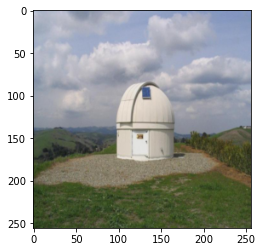

In [37]:
real, _ = val_ds[150]
plt.imshow((real * 0.5 + 0.5).squeeze(0).cpu().permute((1,2,0)).detach().numpy())

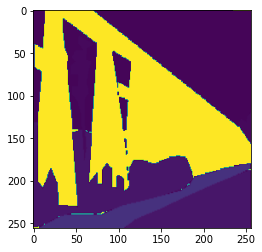

In [38]:
_, segmap = val_ds[10]
plt.imshow((segmap / 255.0).squeeze().cpu().detach().numpy())

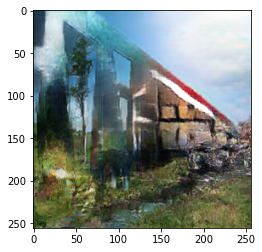

In [39]:
with torch.no_grad():
    one_hot_label_map = torch.zeros(1, 150, 256, 256).to('cuda')
    input_semantics = one_hot_label_map.scatter_(1, segmap.unsqueeze(0).long().to('cuda'), 1.0)
    G_out = GauganTrainer.forward_g(real.unsqueeze(0).to(device='cuda'), input_semantics)
    plt.imshow((G_out * 0.5 + 0.5).squeeze(0).cpu().permute((1,2,0)).detach().numpy())

In [40]:
def plot_losses(history):
    losses_g, losses_d, lrg, lrd = history
    loss_d = [x[0] for x in losses_d]
    d_loss_real = [x[1] for x in losses_d]
    d_loss_fake = [x[2] for x in losses_d]
    loss_g = [x[0] for x in losses_g]
    hinge_g = [x[1] for x in losses_g]
    perceptual_loss = [x[2] for x in losses_g]
    kdl = [x[3] for x in losses_g]
    fm_loss = [x[4] for x in losses_g]
    
    f, ax = plt.subplots(10,1)
    
    f.set_figheight(20)
    f.set_figwidth(15)
    
    ax[0].plot(losses_d, '-b')
    ax[1].plot(d_loss_real, '-r')
    ax[2].plot(d_loss_fake, '-g')
    
    ax[3].plot(loss_g, '-r')
    ax[4].plot(hinge_g, '-g')
    ax[5].plot(perceptual_loss, '-c')
    ax[6].plot(fm_loss, '-m')
    ax[7].plot(kdl, '-y')
    ax[8].plot(lrd, '-y')
    ax[9].plot(lrg, '-y')
    
    l = ['D', 'Dreal', 'Dfake', 'G', 'G_hinge', 'G_perceptual','G_FEATURE_MATCH', 'G_KDL', 'lrd', 'lrg']
    for i in range(8):
        ax[i].title.set_text(l[i])
    
    for i in range(8,10):
        ax[i].title.set_text(l[i])
        ax[i].set_xlabel('batch n°')

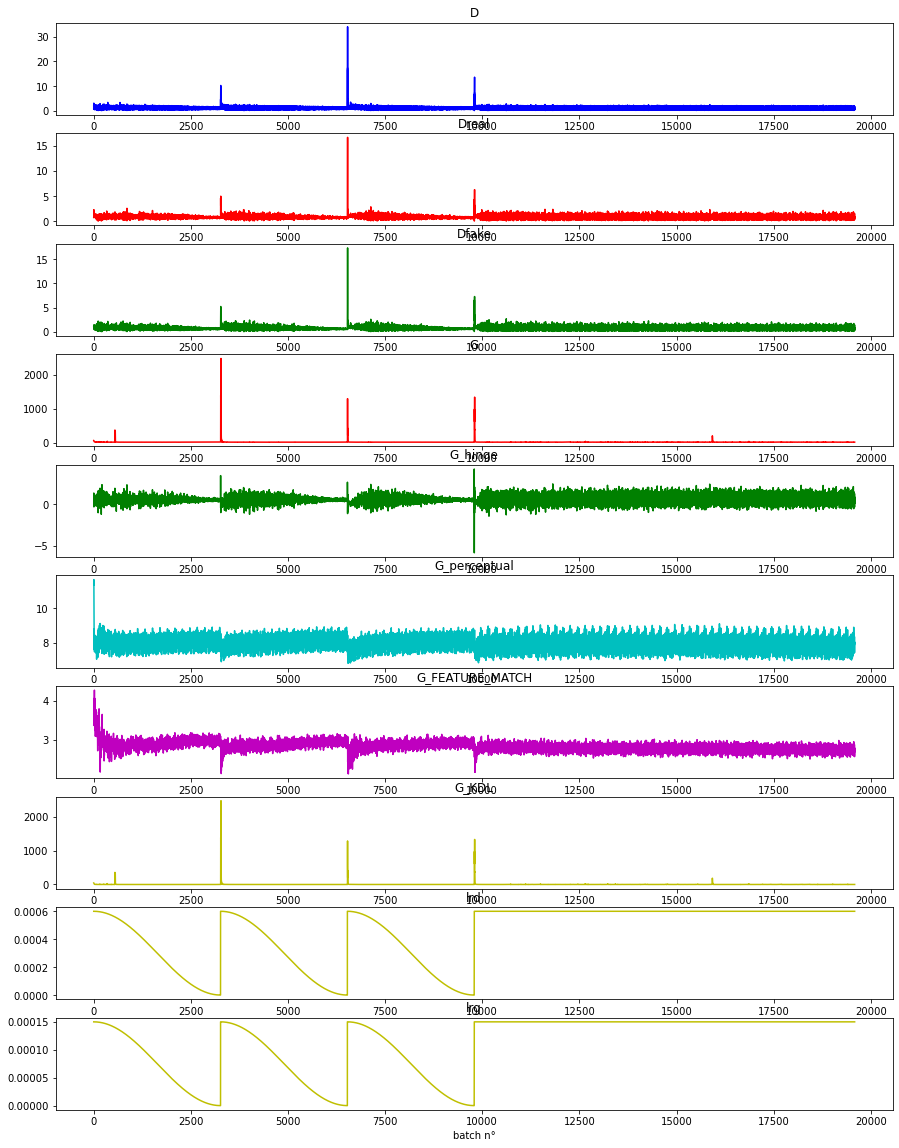

In [41]:
plot_losses(history)

In [42]:
#import cv2
#import os

#video_name = 'videopls3.mp4'

#images = [os.path.join("../input/testrun-budget-gaugan-2/generated", f) for f in os.listdir("../input/testrun-budget-gaugan-2/generated") if 'generated' in f]
#images.sort()
#frame = cv2.imread(images[0])
#height, width, layers = frame.shape

#out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width,height))

#[out.write(cv2.imread(fname)) for fname in images]
#out.release()